# Tutorial on Text Classification (NLP) using ULMFiT and fastai Library in Python
links https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

#### 1. Import the libraries

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

#### 2. Import dataset yang ada di sklearn untuk klasifikasi

In [0]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

bikin dataframe dan cek shape nya. label sebagai label dari teks, teks itu isi artikelnya.

In [0]:
df = pd.DataFrame({'label':dataset.target, 'text':dataset.data})

In [6]:
print(df)

       label                                               text
0         17  Well i'm not sure about the story nad it did s...
1          0  \n\n\n\n\n\n\nYeah, do you expect people to re...
2         17  Although I realize that principle is not one o...
3         11  Notwithstanding all the legitimate fuss about ...
4         10  Well, I will have to change the scoring on my ...
5         15   \n \nI read somewhere, I think in Morton Smit...
6          4  \nOk.  I have a record that shows a IIsi with ...
7         17  \n\n\nSounds like wishful guessing.\n\n\n\n\n'...
8         13   Nobody is saying that you shouldn't be allowe...
9         12  \n  I was wondering if anyone can shed any lig...
10         1  Archive-name: graphics/resources-list/part1\nL...
11         6  I have a Roberto Clemente 1969 Topps baseball ...
12        13  \n\n"Diet Evangelist".  Good term.  Fits Atkin...
13        15  Hi Damon,  No matter what system or explanatio...
14         4  The title says it all.  I 

In [5]:
df.shape

(11314, 2)

supaya bisa jadi binary classification, cuma pilih 2 label, yaitu 1 dan 10

In [0]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

In [8]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

#### 3. Preprocessing data

a. buat teks nya, cuma select huruf

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

b. download stop words

In [17]:
#from nltk.corpus import stopwords 
#stop_words = stopwords.words('english')
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


c. tokenization, remove stop-words, de-tokenization

In [0]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df['text'] = detokenized_doc

#### 4. Split dataset

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 28)

cek shape nya

#### 5. Siapkan language model sama classifier

In [24]:
# preview of my system
from fastai.utils import show_install
show_install()

TypeError: ignored

In [25]:
print(type(df_trn['label'][0]))

<class 'numpy.int64'>


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(path="", train_df = df_trn, valid_df = df_val)

In [0]:

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

#### 6. Fine tuning

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5)

In [56]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,6.722739,5.385423,0.247628


In [57]:
df_trn.shape, df_val.shape

((710, 2), (474, 2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


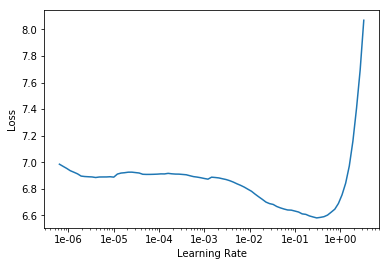

In [0]:
learn.lr_find()
learn.recorder.plot()

save encoder buat classifier

In [0]:
learn.save_encoder('ft_enc')

pakai data_clas untuk fine-tuning

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

fit the model

In [61]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.572145,0.349489,0.905063


#### get prediction

In [62]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,219,30
1,15,210
